### RQ5: How have creators evolved community management from informal interactions to professional engagement strategies, and what video styles are generating the most engagement?

The goal is to help the content creators in the management of their community by identifying strategies to stimulate the engagement of the viewers within the community. To do this, we firstly understand which themes are susceptible to generate the most reactions among the viewers of the community. This will help the content creator to optimise its future content to maintain an active and engaged audience.

Firstly, we analyse interactions within the whole youtube community by studying the comments. The goal is to identify how themes are correlated to each other. For example, if we notice that people who react under videos from the theme A will also react under videos from the theme B but will never react under videos from the theme C, we will thus conclude that themes A and B are close to each other and far from the theme C. Knowing these correlations or "distances" between the themes, we can create clusters of themes, which means groups of themes that often appear together in an author's comments. 

Once themes are grouped together into clusters, it will be easier for the conten creator to indentify which subjects are keen to encourage reactions among its community. Thus the content creator will explore new subjects or deepen some sujects and will also try to collaborate with other content creators that are implied in themes located in the same theme cluster. 

Finally, the contznt creator can now adapt its strategies and its subjects depending on the expectations of the community. This will maintain the audience active and will open new opportunities of partnership. 

We firstly present here the datasets we are using in this task. 

1) youtube_comments.tsv.gz : contains around 8.6 B comments. Each rows corresponds to a comment. It contains an anonymized user id, a video id, the number of replies the comment received, and the number of likes the comment received.

2) yt_metadata_en.jsonl.gz : contains metadata data related to ~73M videos. Each rows correponds to a video. It contains the category of the video, the id of the channel related to the video, the crawl date, the description written by the creator under the video, the number of dislikes, the id of the video, the duration, the number of likes, the tags, the title, the upload date and the view count

We firstly preprocess the data in the following way : 
- Using the "process_comments.py" file, we open the "youtube_comments.tsv.gz" file. We only consider authors who wrote more than 100 comments in total and we keep a list containing the id's of the the videos under which the author commented. We split the "process_comments.py" file in chunks of 100.000.000 lines each and we store each of these chunks in files names "filtered_comments_i.csv" where i goes from 0 to ___.
- Using the "process_metadata.py" file, we read the "yt_metadata_en.jsonl.gz" file. For each row, we only keep the id of the video and the category it belongs to. We store the final data in the "yt_metadata.csv" file.
- Using the "matrix_contruction.py" file, we open the "filtered_comments_i.csv" and "yt_metadata.csv" files and we create based on them a matrix. Each row of the matrix represents an author and each column a category. Noting the matrix $A$, then $A_{ij}$ would be the number of comments the author i wrote unders videos belonging to the category j. The matrix is then stored in the "my_matrix.npy" file.

In [2]:
from matplotlib.dates import DateFormatter, YearLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, pdist, squareform

In [3]:
# Reading data about videos
df_metadata = pd.read_csv("yt_metadata.csv") 

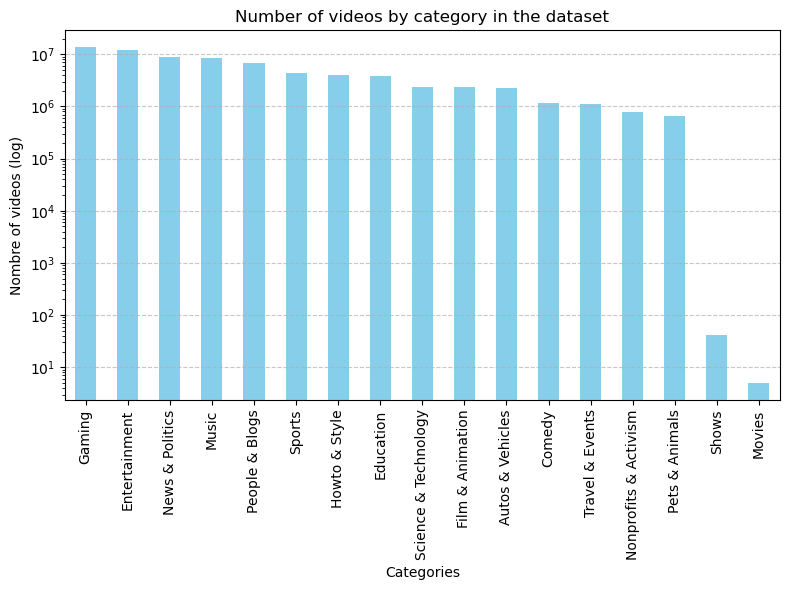

In [4]:
## We visualize here how mush video we have per category

# Counting of the number fo videos
category_counts = df_metadata['Film & Animation'].value_counts()

# Plotting the results
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of videos by category in the dataset')
plt.xlabel('Categories')
plt.ylabel('Nombre of videos (log)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

As we can see on the plot, there are two categories that are under represented compared with the others in the dataset. It is thus useless to consider these categories in our analysis because there are not enough data about them. The two categories are "Shows" and "Movies". 

In [5]:
category_counts

Gaming                   13720303
Entertainment            12276397
News & Politics           8881022
Music                     8305003
People & Blogs            6910666
Sports                    4354412
Howto & Style             3968127
Education                 3795564
Science & Technology      2403004
Film & Animation          2359735
Autos & Vehicles          2256967
Comedy                    1172503
Travel & Events           1096565
Nonprofits & Activism      777449
Pets & Animals             645508
Shows                          41
Movies                          5
Name: Film & Animation, dtype: int64

In [6]:
## Loading the category matrix and the list of categories

# Loading category matrix to a numpy array
category_matrix = np.load("my_matrix.npy")

# Loading the list of all categories to a numpy array
with open("liste_cat.pkl", "rb") as file:
    liste_categories = pickle.load(file)
liste_categories = liste_categories

In [7]:
# Here we want to dump the columns associated with the Shows and Movies categories
index_shows = np.where(liste_categories == "Shows")[0] # Index of the "Shows" category in the list of categories
index_movies = np.where(liste_categories == "Movies")[0] # Index of the "Movies" category in the list of categories
liste_indices = list(range(len(category_matrix[0])))
liste_indices.remove(index_shows); liste_indices.remove(index_movies)
category_matrix = category_matrix[:, liste_indices]  # Selecting only the relevant categories

Before computing whatever with the matrix $A$ described before, we firstly divide each row by it's $l_1$ norm. For each row i : 
$$ 
A_i \leftarrow \frac{A_i}{||A_i||_{l_1}}
$$
The idea behing this step is to have for each row of the matrix (and thus for each author of comments) a distribution of the themes the author commented. 

At this step, we know have a matrix $A$ such that $A_{ij} = $ distribution of comments written by the author i under videos belonging to the category j. The goal is now to establish a notion of distance between the categories based on this matrix. Let's note $A_{:i}$ the i'th column of the matrix $A$, we describe the distance between the category i and the category j as : 
$$
dist(cat_i, cat_j) = 1 - \frac{A_{:i} \cdot A_{j:}}{||A_{:i}|| ||A_{:j}||}
$$


In [8]:
## We compute in this cell the distances between the categories

# Firstly, we divide each row by its l1 norm 
for i in range(len(category_matrix)) : 
    category_matrix[i] = category_matrix[i]/np.sum(category_matrix[i])

# We then compute the distance matrix
similarity_matrix = cosine_similarity(category_matrix.T)   
distance_matrix = 1 - similarity_matrix
np.save("distance_matrix.npy", distance_matrix)

# We create a dataframe based on this matrix
distance_df = pd.DataFrame(distance_matrix, columns=liste_categories[liste_indices], index = liste_categories[liste_indices])


In [9]:
distance_df.to_csv("distance.csv")

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px



# Interactive heatmap
fig = px.imshow(distance_df,
                labels=dict(x="Categories", y="Categories", color="Distance"),
                x=distance_df.columns,
                y=distance_df.index,
                color_continuous_scale='RdBu',  
                text_auto=".2f")


fig.update_traces(
    hovertemplate="<b>Catégorie 1:</b> %{y}<br>"
                  "<b>Catégorie 2:</b> %{x}<br>"
                  "<b>Distance:</b> %{z:.2f}<extra></extra>"
)


fig.update_layout(
    title="Distance matrix between the categories",
    xaxis=dict(tickangle=-45),
    width=800,
    height=800
)

fig.write_html("matrice_distance.html")  # Saving the interactive matrix to use it in the app project

fig.show()


A short distance in the matrix between two categories A and B means that an author who comments under videos belonging to the category A is likely to comment under videos belonging to the category B and a great distance means that the same author is unlikely to comment under videos of both categories. 

### Closest Categories : 

We can thus know what are the closest categories for each category : 
- Film & Animation      : Entertainment (0.50), Comedy (0.59), Gaming (0.64)
- Gaming                : Entertainment (0.56), Comedy (0.62), Film & Animation (0.64)
- Education             : Entertainment (0.70), News & Politics (0.72), People & Blogs (0.73)
- People & Blogs        : Entertainment (0.42), Comedy (0.51), Howto & Style (0.60)
- Entertainment         : Comedy (0.40), People & Blogs (0.42), Film & Animation (0.50)
- Autos & Vehicles      : Science & Technology (0.87), People & Blogs (0.88), Entertainment (0.89)
- Comedy                : Entertainment (0.40), People & Blogs (0.51), Film & Animation (0.59)
- Sports                : ENtertainment (0.78), People & Blogs (0.84), Gaming (0.85)
- News & Politics       : Education (0.72), Entertainment (0.76), Nonprofits & Activism (0.80)
- Music                 : Entertainment (0.58), Comedy (0.66), People & Blogs (0.71)
- Howto & Style         : People & Blogs (0.60), Entertainment (0.69), Comedy (0.73)
- Science & Technology  : Education (0.77), Gaming (0.78), Entertainment (0.80)
- Travel & Events       : People & Blogs (0.81), Entertainment (0.84), Education (0.87)
- Pets & Animals        : Entertainment (0.81), People & Blogs (0.83), Comedy (0.84)
- Nonprofits & Activism : Education (0.80), News & Politics (0.80), People & Blogs (0.87)

Firstly, we notice that this is not that surprising. It is logical that people who comment content about Nonprofits & Activism will be more likely to comment under content about Education, News & Politics ... and the analysis is the same for the orther categories. 

We also notice that some themes seem to be close to a lot of different themes (for example Entertainment or People & Blog) and others seem to be quite isolated (for example Autos & Vehicles and Nonprofits & Activism). Moreover, Entertainment is in the top 3 of 9 categories while Nonprofits & Activism is in the top 3 of None. We decide to study how isolated is a category compared to the other by computing the mean of the distances of each category. 



In [11]:
distance_df.mean().sort_values()

Entertainment            0.642682
People & Blogs           0.680323
Comedy                   0.692595
Film & Animation         0.737471
Education                0.758838
Gaming                   0.759284
Music                    0.762077
Howto & Style            0.796859
News & Politics          0.804457
Science & Technology     0.811153
Sports                   0.830895
Pets & Animals           0.836359
Travel & Events          0.839529
Nonprofits & Activism    0.852436
Autos & Vehicles         0.859666
dtype: float64

In [12]:
similarity_df = pd.DataFrame(similarity_matrix, columns=liste_categories[liste_indices], index = liste_categories[liste_indices])

Without surprises, we notice that Entertainment, People & Blogs and Comedy are the three categories with the least distance mean woth the other categories. This can be firstly explained by the fact that they are liked by a range variety of people. Indeed, everybody wants to be entertained in some ways and want to laugh in front of comedies whatever are the other contents the perso is consuming. Secondly, this can be explained by the fact that Entertainment, People & Blogs and Comedy are categories that can englobe a lot of different kinds of content. We can entertain people or make them laugh in a lot of different ways that's why different kind of people will still consume this content and react about it in comments. 

In [13]:
df_sim = 1 - distance_df

In [14]:
df_sim.head(20)

,Film & Animation,Gaming,Education,People & Blogs,Entertainment,Autos & Vehicles,Comedy,Sports,News & Politics,Music,Howto & Style,Science & Technology,Travel & Events,Pets & Animals,Nonprofits & Activism
Film & Animation,1.000000,0.360991,0.202427,0.328482,0.496409,0.057436,0.412233,0.099886,0.114749,0.260923,0.169800,0.123677,0.088831,0.147912,0.074178
Gaming,0.360991,1.000000,0.155894,0.283391,0.437381,0.063227,0.384184,0.152209,0.071032,0.215423,0.100928,0.158568,0.071498,0.120857,0.035151
Education,0.202427,0.155894,1.000000,0.271795,0.296395,0.098234,0.218897,0.114772,0.275164,0.167453,0.144634,0.234681,0.127269,0.109376,0.200433
People & Blogs,0.328482,0.283391,0.271795,1.000000,0.578110,0.116711,0.492275,0.162698,0.201727,0.293333,0.403632,0.171332,0.191362,0.167361,0.132938
Entertainment,0.496409,0.437381,0.296395,0.578110,1.000000,0.110205,0.599712,0.216149,0.236041,0.421284,0.305736,0.203461,0.156452,0.189815,0.112614
Autos & Vehicles,0.057436,0.063227,0.098234,0.116711,0.110205,1.000000,0.072771,0.086526,0.078208,0.069468,0.046599,0.134606,0.092365,0.044507,0.034141
Comedy,0.412233,0.384184,0.218897,0.492275,0.599712,0.072771,1.000000,0.139778,0.159909,0.342802,0.269268,0.169727,0.105517,0.156926,0.087081
Sports,0.099886,0.152209,0.114772,0.162698,0.216149,0.086526,0.139778,1.000000,0.112357,0.134877,0.059319,0.086448,0.071081,0.058637,0.041834
News & Politics,0.114749,0.071032,0.275164,0.201727,0.236041,0.078208,0.159909,0.112357,1.000000,0.114285,0.064848,0.121464,0.109073,0.076986,0.197297
Music,0.260923,0.215423,0.167453,0.293333,0.421284,0.069468,0.342802,0.134877,0.114285,1.000000,0.159393,0.125947,0.092799,0.095787,0.075070


We finish the analysis by simplifying the task to the content creator. We now try to identify clusters of categories based of the distance matrix. For that, we use hierarchical clustering as following : 

In [15]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import plotly.figure_factory as ff

# Créer un dendrogramme interactif avec Plotly
fig = ff.create_dendrogram(
    distance_matrix,
    labels=liste_categories[liste_indices],
    orientation='bottom',
    linkagefun=lambda x: linkage(x, 'ward')
)

# Mise en forme du graphique
fig.update_layout(
    title="Categories clustering",
    xaxis_title="Categories",
    yaxis_title="Distance",
    width=1000,
    height=600
)

fig.write_html("dendogramme.html")

# Afficher le dendrogramme interactif
fig.show()


Mid-level clusters seem to be the following : 
- People & Blogs, Entertainment and Comedy
- Music, Film & Animation and Gaming
- Nonprofits & Activism, Education and News & Politics
- Howto & style and Pets & Animals
- Sports, Autos & Vehicles and Science & Technology